In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob as glob

plt.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline

from utilities import *
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label


In [2]:
vehicle_filenames = glob.glob('train_images_vehicles/*/*.png')
non_vehicle_filenames = glob.glob('train_images_non_vehicles/*/*.png')

print(len(vehicle_filenames))
print(len(non_vehicle_filenames))

8792
8968


In [3]:
# utility functions

def getHOGFeatures(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
  # img: must be greyscale
  # orient: number of orientation bins
  # 
  if vis == True:
    features, hog_image = hog(img, 
                              orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=False,
                              visualise=True, 
                              feature_vector=False)
    return features, hog_image
  else:      
    features = hog(img, 
                   orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=False, 
                   visualise=False, 
                   feature_vector=feature_vec)
    return features
  
def getColorHistogram(imgs, nbins=32, channels=[], bins_range=[0, 256]):
  # we use opencv's histogram calculator bc it is ~40x faster (according to opencv's tutorial)
  # imgs, channels, histSize, ranges must be lists i.e. [...]
  tbr = []
  for c in channels:
    hist = cv2.calcHist(images = imgs,channels=[c],mask=None,histSize=nbins,ranges=bins_range)
    tbr.append(hist)
  return np.reshape(np.concatenate(tbr), (-1))

def spatialBinning(img, color_space='RGB', size=(32, 32)):
  # img: should be RGB if color_space is not RGB
  # Convert image to new color space if specified
  if color_space != 'RGB':
    if color_space == 'HSV':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
  else: feature_image = np.copy(img)             
  # Use cv2.resize().ravel() to create the feature vector
  features = cv2.resize(feature_image, size).ravel() 
  # Return the feature vector
  return features

In [4]:
def imagePipeline(img, print_stats=False, scaler=None):
  
  do_hog = True
  do_color_hist = True
  do_spatial = True
  
  features = []
  
  if do_hog == True:
    g_im = greyscale(img)
    num_orient_bins = 5
    pix_per_cell = 8
    cell_per_block = 5
    hog_features = getHOGFeatures(img=g_im, 
                                  orient=num_orient_bins, 
                                  pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, 
                                  vis=False, 
                                  feature_vec=True)
    if print_stats == True:
      print('hog: ', hog_features.shape)
      print('  mean: ', np.mean(hog_features))
      print('  std: ', np.std(hog_features))
      print('  min, max: ', np.min(hog_features), np.max(hog_features))
    features.append(hog_features)
    
  if do_color_hist == True:
    nbins = [32]
    channels = [0, 1, 2]
    b_range = [0, 256]
    hist_features = getColorHistogram(imgs=[img], 
                                      nbins=nbins, 
                                      channels=channels, 
                                      bins_range=b_range)
    if print_stats == True:
      print('color histogram: ', hist_features.shape)
      print('  mean: ', np.mean(hist_features))
      print('  std: ', np.std(hist_features))
      print('  min, max: ', np.min(hist_features), np.max(hist_features))
    features.append(hist_features)

  if do_spatial == True:
    new_size = (32, 32)
    c_space = 'YCrCb'
    bin_features = spatialBinning(img=img, 
                                  color_space=c_space,
                                  size=new_size)
    if print_stats == True:
      print('spatial binning (image resizing): ', bin_features.shape)
      print('  mean: ', np.mean(bin_features))
      print('  std: ', np.std(bin_features))
      print('  min, max: ', np.min(bin_features), np.max(bin_features))
    features.append(bin_features)
  
  tbr = np.concatenate(features)
  if scaler is not None:
    tbr = scaler.transform(tbr.reshape(1, -1))
  return tbr

# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicle_filenames))
# Read in the image
im, im_shape = loadImage(vehicle_filenames[ind], greyscale=False)

print(im_shape)
test_f = imagePipeline(im, print_stats=True)
print(test_f.shape)

(64, 64)
hog:  (2000,)
  mean:  0.0079999999999
  std:  0.00925128927285
  min, max:  0.0 0.0748566594122
color histogram:  (96,)
  mean:  128.0
  std:  196.114
  min, max:  1.0 807.0
spatial binning (image resizing):  (3072,)
  mean:  101.268880208
  std:  39.8716524234
  min, max:  5 204
(5168,)


In [5]:
def extractFeatures(filenames):
  f_list = []
  for fname in filenames:
    img, im_size = loadImage(fname)
    features = imagePipeline(img)
    f_list.append(features)
  return np.array(f_list)

train_features_vehicles = extractFeatures(vehicle_filenames)
train_features_non_vehicles = extractFeatures(non_vehicle_filenames)

print("Done")

Done


In [6]:
# Make sure features aren't dominating eachother
# Interesting that the color peaks on vehicle features are significantly higher (more primary colors? Higher brightness?)
#vehicle_feature_avgs = np.sum(train_features_vehicles, axis=0) / len(train_features_vehicles)
#non_vehicle_feature_avgs = np.sum(train_features_non_vehicles, axis=0) / len(train_features_vehicles)

#ind=np.arange(0, len(vehicle_feature_avgs))
#f = plt.figure(1)
#plt.bar(ind, vehicle_feature_avgs, color='blue')
#f = plt.figure(2)
#plt.bar(ind, non_vehicle_feature_avgs, color='red')


In [7]:
vehicle_labels = np.ones((len(train_features_vehicles)))
non_vehicle_labels = np.zeros((len(train_features_non_vehicles)))
X_data = np.concatenate([train_features_vehicles, train_features_non_vehicles])
y_data = np.concatenate([vehicle_labels, non_vehicle_labels])
X_scaler = StandardScaler().fit(X_data)
scaled_X = X_scaler.transform(X_data)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_data, test_size=0.2, random_state=42)

In [8]:
import time
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t1, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the pre

14.1856 Seconds to train SVC...
Test Accuracy of SVC =  0.97747748


In [15]:
im_shape = (720, 1280)
near_min_row = im_shape[0]-40
far_min_row = 460

near_max_height = 290
far_max_height = 80

near_width = 300
far_width = 70

near_step_size = 30
far_step_size = 10

sampling_num = 30
min_row_sampling=np.geomspace(start=near_min_row, stop=far_min_row, num=sampling_num, dtype=np.uint16)
max_height_sampling=np.geomspace(start=near_max_height, stop=far_max_height, num=sampling_num, dtype=np.uint16)
width_sampling=np.geomspace(start=near_width, stop=far_width, num=sampling_num, dtype=np.uint16)
step_size_sampling=np.geomspace(start=near_width, stop=far_width, num=sampling_num, dtype=np.uint16)

(720, 1280)


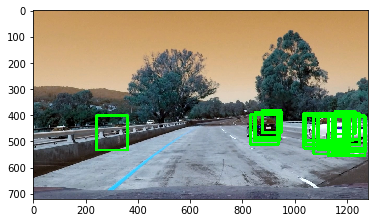

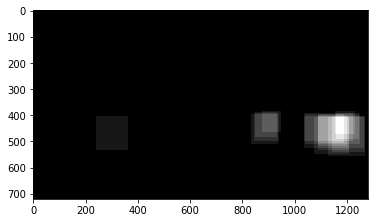

In [16]:
def sliding_window_horizontal(image_strip, step_size, window_width):
  # slide a window across the image
  for c in np.arange(start=int(window_width/2), stop=image_strip.shape[1]-int(window_width/2), step=step_size, dtype=np.uint16):
    yield (c, image_strip[:, int(c-window_width/2):c + int(window_width/2)])

def horizontal_strip(image, min_row, height):
  return image[min_row-height:min_row, :]

def findHotWindows(img, min_row_sampling, max_height_sampling, width_sampling, step_size_sampling, feature_scaler, classifier):
  hot_windows = []
  sampling_num = min_row_sampling.shape[0]
  for i in range(sampling_num):
    strip = horizontal_strip(img, min_row_sampling[i], max_height_sampling[i])
    for (c, window) in sliding_window_horizontal(strip, step_size_sampling[i], width_sampling[i]):
      resized_window = cv2.resize(window, (64, 64))
      features = imagePipeline(resized_window, scaler=feature_scaler)
      #scaled_features = feature_scaler.transform(features.reshape(1,-1))
      prediction = classifier.predict(features)
      if prediction == 1:
        hot_windows.append((c, min_row_sampling[i], max_height_sampling[i], width_sampling[i]))
  return hot_windows

def createNominalHeatMap(im, hot_windows):
  heatmap = np.zeros_like(im[:,:,0])
  plus = max(int(255/len(hot_windows)), 1)
  for w in hot_windows:
    #w = (center_col, min_row, height, width)
    heatmap[int(w[1]-w[2]):int(w[1]), int(w[0]-w[3]/2):int(w[0]+w[3]/2)] += plus
  return heatmap

im_fname = 'test_images/test1.jpg'
test_im, im_shape = loadImage(im_fname)
print(im_shape)
hot_windows = findHotWindows(test_im, min_row_sampling, max_height_sampling, width_sampling, step_size_sampling, X_scaler, svc)

for w in hot_windows:
  drawBox(test_im, w[0], w[1], w[2], w[3], c=[0, 255, 0])

heatmap = createNominalHeatMap(test_im, hot_windows)

f_num = 0
f_num = showImage(test_im, f_num)
f_num = showImage(heatmap, f_num)

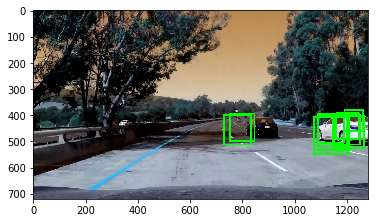

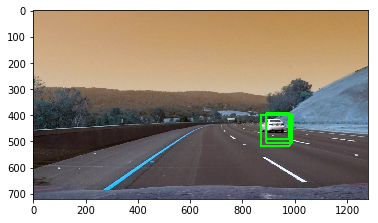

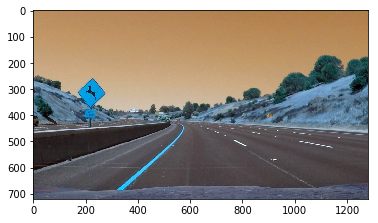

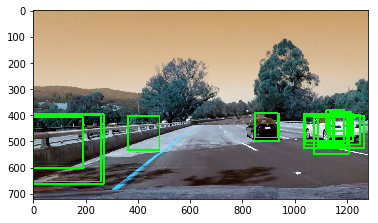

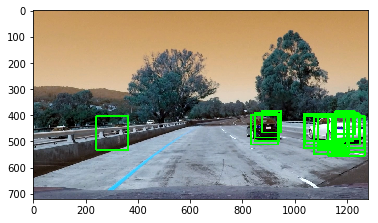

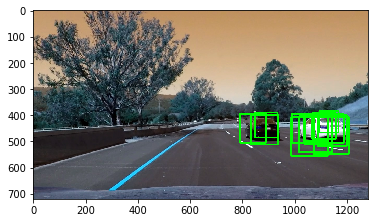

In [18]:
test_filenames = glob.glob('test_images/test*.jpg')

f_num = 0
for fname in test_filenames:
  im, im_shape = loadImage(fname)
  hot_windows = findHotWindows(im, min_row_sampling, max_height_sampling, width_sampling, step_size_sampling, X_scaler, svc)
  if hot_windows:
    for w in hot_windows:
      drawBox(im, w[0], w[1], w[2], w[3], c=[0, 255, 0], thickness = 5)
  f_num = showImage(im, f_num)


In [23]:
from moviepy.editor import VideoFileClip

def pipelineWrapper(file, im_filepath=False):
  global min_row_sampling
  global max_height_sampling
  global width_sampling
  global step_size_sampling
  global X_scaler
  global svc
  
  if im_filepath == True:
    im = cv2.imread(file)
  else:
    im = file
  hot_windows = findHotWindows(im, min_row_sampling, max_height_sampling, width_sampling, step_size_sampling, X_scaler, svc)
  if hot_windows:
    for w in hot_windows:
      drawBox(im, w[0], w[1], w[2], w[3], c=[0, 255, 0], thickness = 5)
  return im

output = 'project_output.mp4'
clip1 = VideoFileClip('videos/project_video.mp4')
output_clip = clip1.fl_image(pipelineWrapper)
%time output_clip.write_videofile(output, audio=False)



OSError: [Errno 12] Cannot allocate memory